In [2]:
# code to calculate the projections for maintenance and propoagation
#
#
# Version 2 Oct 17, 2024
# A. Thornton, A. Aiyyer
# NCSU Tropical and Large Scale Dynamics
#
#

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
# Any import of metpy will activate the accessors
from metpy.units import units
import geocat.viz as gv
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [4]:
term_labels = [
        r'$\bar{u}\frac{\partial h^{\prime}}{\partial x}$',
        r'$\bar{v}\frac{\partial h^{\prime}}{\partial y}$',    
        r'$\bar{\omega}\frac{\partial h^{\prime}}{\partial p}$',
        r"$u^{\prime} \frac{\partial \bar{h}}{\partial x}$",
        r"$v^{\prime} \frac{\partial \bar{h}}{\partial y}$",
        r"${\omega}^{\prime} \frac{\partial \bar{h}}{\partial p}$",
        r"$u^{\prime} \frac{\partial h^{\prime}}{\partial x}$",
        r"$v^{\prime} \frac{\partial h^{\prime}}{\partial y}$",
        r"$\omega^{\prime} \frac{\partial h^{\prime}}{\partial p}$",
        r'SSHF',
        r'SLHF',
        r'Q',
        r'Res'
    ]

In [5]:
def var_list(EnerVar):
    variables = [
        'ubar_'+EnerVar+'p_dx_vint',
        'vbar_'+EnerVar+'p_dy_vint',
        'wbar_'+EnerVar+'p_dp_vint',
        'up_'+EnerVar+'bar_dx_vint',
        'vp_' + EnerVar+'bar_dy_vint', 'wp_' + EnerVar+'bar_dp_vint',
        'up_'+EnerVar+'p_dx_vint',
        'vp_' + EnerVar+'p_dy_vint', 'wp_' + EnerVar+'p_dp_vint',
        'sshf', 'slhf',
        'Q_prime']
    return variables
def name_list(EnerVar):
    varNames =  [
        'ubar_'+ EnerVar+'p_dx_vint_prime', 
        'vbar_'+ EnerVar+'p_dy_vint_prime', 
        'wbar_'+ EnerVar+'p_dp_vint_prime',
        'up_' + EnerVar+'bar_dx_vint_prime', 
        'vp_' + EnerVar+'bar_dy_vint_prime', 'wp_' + EnerVar+'bar_dp_vint_prime',
        'up_' + EnerVar+'p_dx_vint_prime', 
        'vp_' + EnerVar+'p_dy_vint_prime', 'wp_' + EnerVar+'p_dp_vint_prime',
        'SSHF_prime', 'SLHF_prime', 
        'Q_prime']
    return varNames

In [6]:
def plotting():
    # Negative bars in one color, positive in another
    def set_bar_color(value):
        if value >= 0:
            return  '///'  #None  
        else:
            return '///'  

    # Plot the total bar
    for i in range(len(term_labels)):
        result = h_proj[i]
        hatch = set_bar_color(result)
        ax[iplot,j].bar(i, result, color='white', edgecolor='black', alpha=0.7, hatch=hatch, capstyle='projecting', label='MSE')
    
    # Create a figure and axis object for plotting
    bar_width = 0.34  
    category_positions = range(len(term_labels))
    
    #Plot Bar 1 on the left half of the total bar
    ax[iplot,j].bar([pos - bar_width / 2 for pos in category_positions], s_proj, color='gold', width=bar_width, label='DSE', alpha=0.6)#, edgecolor='black')
    
    # Plot Bar 2 on the right half of the total bar
    ax[iplot,j].bar([pos + bar_width / 2 for pos in category_positions], q_proj, color='lightskyblue', width=bar_width, label='Moisture', alpha=0.7)#, edgecolor='black')
    
    
    # Set x-ticks and labels for ocean terms
    ax[iplot,j].set_xticks(np.arange(len(term_labels)))
    ax[iplot,j].set_xticklabels(term_labels, rotation='horizontal', fontsize=14)
    Rtitle = 'Lat=' + str(latRef) + ' Lon=' + str(lonRef) + ', Level = ' +str(level)
    # Use geocat.viz.util convenience function to set titles and labels
    gv.set_titles_and_labels(ax[iplot,j],
                         righttitle=Rtitle,                         
                         righttitlefontsize=15)  
    
    # Get the handles and labels from the legend
    handles, labels = ax[iplot,j].get_legend_handles_labels()
    
    # Remove duplicates from the handles and labels
    handles = handles[-3:]  # Keep only the first handle (MSE)
    labels = labels[-3:]  # Keep only the first label (MSE)
    
    # Update the legend with the filtered handles and labels
    ax[iplot,j].legend(handles, labels)
    ax[iplot,j].set_ylim(-0.75, 2)    
    ax[iplot,j].tick_params(axis='y', labelsize=15)
    
    plt.tight_layout()
    ax[iplot,j].hlines(y=0, xmin=-0.4, xmax=12.4, color='black', linewidth=0.8)

In [7]:
path_composite = '/glade/derecho/scratch/aiyyer/data/composites/refV'
plotsdir = '/glade/u/home/athornton/plots/projections/'

In [8]:
itracks = [5, 3, 1]

# Selections:
levels = [850,600]
stormTracks = ['N', 'N', 'O'],['S', 'S', 'O']
Ltitle = ['Northern Track','Southern Track']

deltaLon = 15
deltaLat = 5

label = ['(a) ','(b) ','(c) '], ['(d) ','(e) ','(f) ']

In [9]:
def lat_lon_bounds(stormTrack, lonRef, latRef, deltaLon):
    
    if (stormTrack == 'N'):
        latS = 17 #15.
        latN = 22.
    if (stormTrack == 'S' ):
        latS = 0. #5.
        latN = 17. #25.
    if (stormTrack == 'O' ):
        latS = 5.
        latN = 20. #25.

    lonW = lonRef - deltaLon
    lonE = lonRef + deltaLon
    return latS, latN, lonW, lonE

In [10]:
def mse_projection(mse, mse_tend, EnerVar):
    variables = var_list(EnerVar)
    varNames = name_list(EnerVar)
    h_proj = []
    firstTime = True
    for variab, varNam in zip(variables, varNames):
        fileName = path_composite + str(level) + '/' + variab + '_Lag_Composite_RefV_' +  \
        str(level) + 'hPa' + '_track_point_' + str(itrack) + '.nc'    
        df = xr.open_dataset(fileName)
        lonRef = df.Reflon.values
        latRef = df.Reflat.values
        latS,latN,lonW,lonE = lat_lon_bounds(stormTrack,lonRef,latRef,deltaLon)
        forc = df[varNam].sel(latitude=slice(latN, latS),
                              longitude=slice(lonW, lonE),
                              Lag=0).metpy.quantify()

        numer = xr.dot(forc, mse_tend, dims=['latitude', 'longitude'], optimize=True)
        frac = (numer/denom)
        print(variab, "numer = ", numer.values , "  Projection = ", frac.values)
        h_proj.append(frac.values)

        if (firstTime):
            sum_forc = forc
            firstTime=False
        else:
            sum_forc = forc + sum_forc  # Add to previous value 

    residual = mse_tend - sum_forc
    numer = xr.dot(residual, mse_tend, dims=['latitude', 'longitude'], optimize=True)
    frac = (numer / denom)
    print('residual = ', numer.values, " Projection = ", frac.values)
    # add the residual to the proj array
    h_proj.append(frac.values)
    return h_proj

In [11]:
# mse
def mse_func():
    variab = 'mse_vint'
    varNam = 'mse_vint_prime'  
    fileName = path_composite + str(level) + '/' + variab + '_Lag_Composite_RefV_' +  \
    str(level) + 'hPa' + '_track_point_' + str(itrack) + '.nc'
    #print(fileName)
    df = xr.open_dataset(fileName)
    lonRef = df.Reflon.values
    latRef = df.Reflat.values
    latS,latN,lonW,lonE = lat_lon_bounds(stormTrack,lonRef,latRef,deltaLon)
    mse = df[varNam].sel(latitude=slice(latN, latS), longitude=slice(lonW, lonE), Lag=0).metpy.quantify()    
 
    variab = 'hp_vint_tend'
    varNam = 'hp_vint_tend_prime'  
    fileName = path_composite + str(level) + '/' + variab + '_Lag_Composite_RefV_' +  \
    str(level) + 'hPa' + '_track_point_' + str(itrack) + '.nc'
    print(fileName)
    df = xr.open_dataset(fileName)
    lonRef = df.Reflon.values
    latRef = df.Reflat.values
    mse_tend = df[varNam].sel(latitude=slice(latN, latS), longitude=slice(lonW, lonE), Lag=0).metpy.quantify()
    print('ref lat/lon=', latRef, lonRef)

    mse.attrs['lonRef'] = lonRef
    mse.attrs['latRef'] = latRef
    return mse, mse_tend

/glade/derecho/scratch/aiyyer/data/composites/refV850/hp_vint_tend_Lag_Composite_RefV_850hPa_track_point_5.nc
ref lat/lon= 21.5 14.0
ubar_hp_dx_vint numer =  1924848.2967835062   Projection =  0.3517297355993491
vbar_hp_dy_vint numer =  -4418.119619508031   Projection =  -0.0008073280622751531
wbar_hp_dp_vint numer =  118886.49572064573   Projection =  0.021724265634872026
up_hbar_dx_vint numer =  26165.64147058555   Projection =  0.004781277657888869
vp_hbar_dy_vint numer =  3034956.640790386   Projection =  0.55458110574454
wp_hbar_dp_vint numer =  -298434.77600175847   Projection =  -0.05453332869512657
up_hp_dx_vint numer =  -290977.6217307671   Projection =  -0.053170674347538596
vp_hp_dy_vint numer =  936125.9895747057   Projection =  0.17105937509517072
wp_hp_dp_vint numer =  -191493.95313098264   Projection =  -0.034991909552657186
sshf numer =  -30646.583194691684   Projection =  -0.005600085275346115
slhf numer =  27797.779380238626   Projection =  0.005079520088933043
Q_prim

/glade/derecho/scratch/athornton/tmp/ipykernel_39905/1382697954.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV850/hp_vint_tend_Lag_Composite_RefV_850hPa_track_point_3.nc
ref lat/lon= 21.5 -11.0
ubar_hp_dx_vint numer =  5548764.670849087   Projection =  0.5039995558506205
vbar_hp_dy_vint numer =  -7380.457863961206   Projection =  -0.0006703739852138047
wbar_hp_dp_vint numer =  219384.96794344566   Projection =  0.019926944637729524
up_hbar_dx_vint numer =  283926.3061094722   Projection =  0.025789295575150775
vp_hbar_dy_vint numer =  5895376.475214273   Projection =  0.5354826346646124
wp_hbar_dp_vint numer =  -970883.2989784762   Projection =  -0.08818625054305275
up_hp_dx_vint numer =  -734582.5753945746   Projection =  -0.06672283178263119
vp_hp_dy_vint numer =  541749.9823410083   Projection =  0.04920766453052119
wp_hp_dp_vint numer =  -142240.50601197642   Projection =  -0.012919840019640546
sshf numer =  -100214.0999487316   Projection =  -0.009102541711577322
slhf numer =  -51211.86466275548   Projection =  -0.0046516222214126116
Q_pri

/glade/derecho/scratch/athornton/tmp/ipykernel_39905/1382697954.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV850/hp_vint_tend_Lag_Composite_RefV_850hPa_track_point_1.nc
ref lat/lon= 12.0 -34.0
ubar_hp_dx_vint numer =  18624125.222129993   Projection =  0.7034719715890959
vbar_hp_dy_vint numer =  -263199.4813253971   Projection =  -0.009941592200486129
wbar_hp_dp_vint numer =  46845.64266616039   Projection =  0.0017694574222237318
up_hbar_dx_vint numer =  382904.7375304023   Projection =  0.014463108867054271
vp_hbar_dy_vint numer =  30275.72109806313   Projection =  0.0011435769980127017
wp_hbar_dp_vint numer =  982778.8487260238   Projection =  0.037121602550645276
up_hp_dx_vint numer =  775410.600431753   Projection =  0.029288872221963337
vp_hp_dy_vint numer =  4655689.48018944   Projection =  0.1758550814426337
wp_hp_dp_vint numer =  2967.1379412676006   Projection =  0.00011207497547536417
sshf numer =  -25410.532738879578   Projection =  -0.000959808707885422
slhf numer =  -874961.4811032601   Projection =  -0.0330491161778084
Q_prime n

/glade/derecho/scratch/athornton/tmp/ipykernel_39905/1382697954.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV600/hp_vint_tend_Lag_Composite_RefV_600hPa_track_point_5.nc
ref lat/lon= 8 14.0
ubar_hp_dx_vint numer =  1628181.244374735   Projection =  0.4581670365390981
vbar_hp_dy_vint numer =  -152513.23196895284   Projection =  -0.04291692694878672
wbar_hp_dp_vint numer =  -29313.30153593382   Projection =  -0.008248706059166907
up_hbar_dx_vint numer =  97081.34177737385   Projection =  0.02731850082357386
vp_hbar_dy_vint numer =  1219054.2438216226   Projection =  0.3430394940378118
wp_hbar_dp_vint numer =  -160393.5369755627   Projection =  -0.04513442945618673
up_hp_dx_vint numer =  49407.717446890325   Projection =  0.013903235627490624
vp_hp_dy_vint numer =  277131.50590769935   Projection =  0.07798426694327203
wp_hp_dp_vint numer =  207294.08130516278   Projection =  0.05833215144309953
sshf numer =  -53565.137024609125   Projection =  -0.015073125413504307
slhf numer =  -77692.00147732592   Projection =  -0.021862378161300725
Q_prime num

/glade/derecho/scratch/athornton/tmp/ipykernel_39905/1382697954.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV600/hp_vint_tend_Lag_Composite_RefV_600hPa_track_point_3.nc
ref lat/lon= 12.0 -11.0
ubar_hp_dx_vint numer =  7354822.057040311   Projection =  0.6897329306192057
vbar_hp_dy_vint numer =  -220400.40080202412   Projection =  -0.020669081206296604
wbar_hp_dp_vint numer =  55926.03164412448   Projection =  0.005244725896105115
up_hbar_dx_vint numer =  341608.67715603317   Projection =  0.03203595575697685
vp_hbar_dy_vint numer =  1429662.2869684806   Projection =  0.13407328570819851
wp_hbar_dp_vint numer =  730614.2056503664   Projection =  0.0685167735272223
up_hp_dx_vint numer =  -199761.67700186296   Projection =  -0.018733588091640073
vp_hp_dy_vint numer =  937989.6894057813   Projection =  0.08796438205396845
wp_hp_dp_vint numer =  202655.90942980372   Projection =  0.019005008310774518
sshf numer =  -62976.6782585956   Projection =  -0.00590593334809295
slhf numer =  -7817.464179187192   Projection =  -0.0007331193652958683
Q_prime n

/glade/derecho/scratch/athornton/tmp/ipykernel_39905/1382697954.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV600/hp_vint_tend_Lag_Composite_RefV_600hPa_track_point_1.nc
ref lat/lon= 12.0 -34.0
ubar_hp_dx_vint numer =  18561642.355138104   Projection =  0.7350143778114525
vbar_hp_dy_vint numer =  -305308.6920701448   Projection =  -0.012089785701546354
wbar_hp_dp_vint numer =  46950.32538168314   Projection =  0.001859165451968236
up_hbar_dx_vint numer =  234887.6635272695   Projection =  0.009301214114563047
vp_hbar_dy_vint numer =  -1200543.5909220364   Projection =  -0.04753980190081742
wp_hbar_dp_vint numer =  701547.7070258686   Projection =  0.027780281589249133
up_hp_dx_vint numer =  1504292.7032008504   Projection =  0.059567830482598186
vp_hp_dy_vint numer =  4189440.8691186407   Projection =  0.16589584126647708
wp_hp_dp_vint numer =  322394.7139215892   Projection =  0.012766367626794792
sshf numer =  -16500.413180430096   Projection =  -0.000653392662965975
slhf numer =  -771808.1266015725   Projection =  -0.030562493291809618
Q_pri

/glade/derecho/scratch/athornton/tmp/ipykernel_39905/1382697954.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


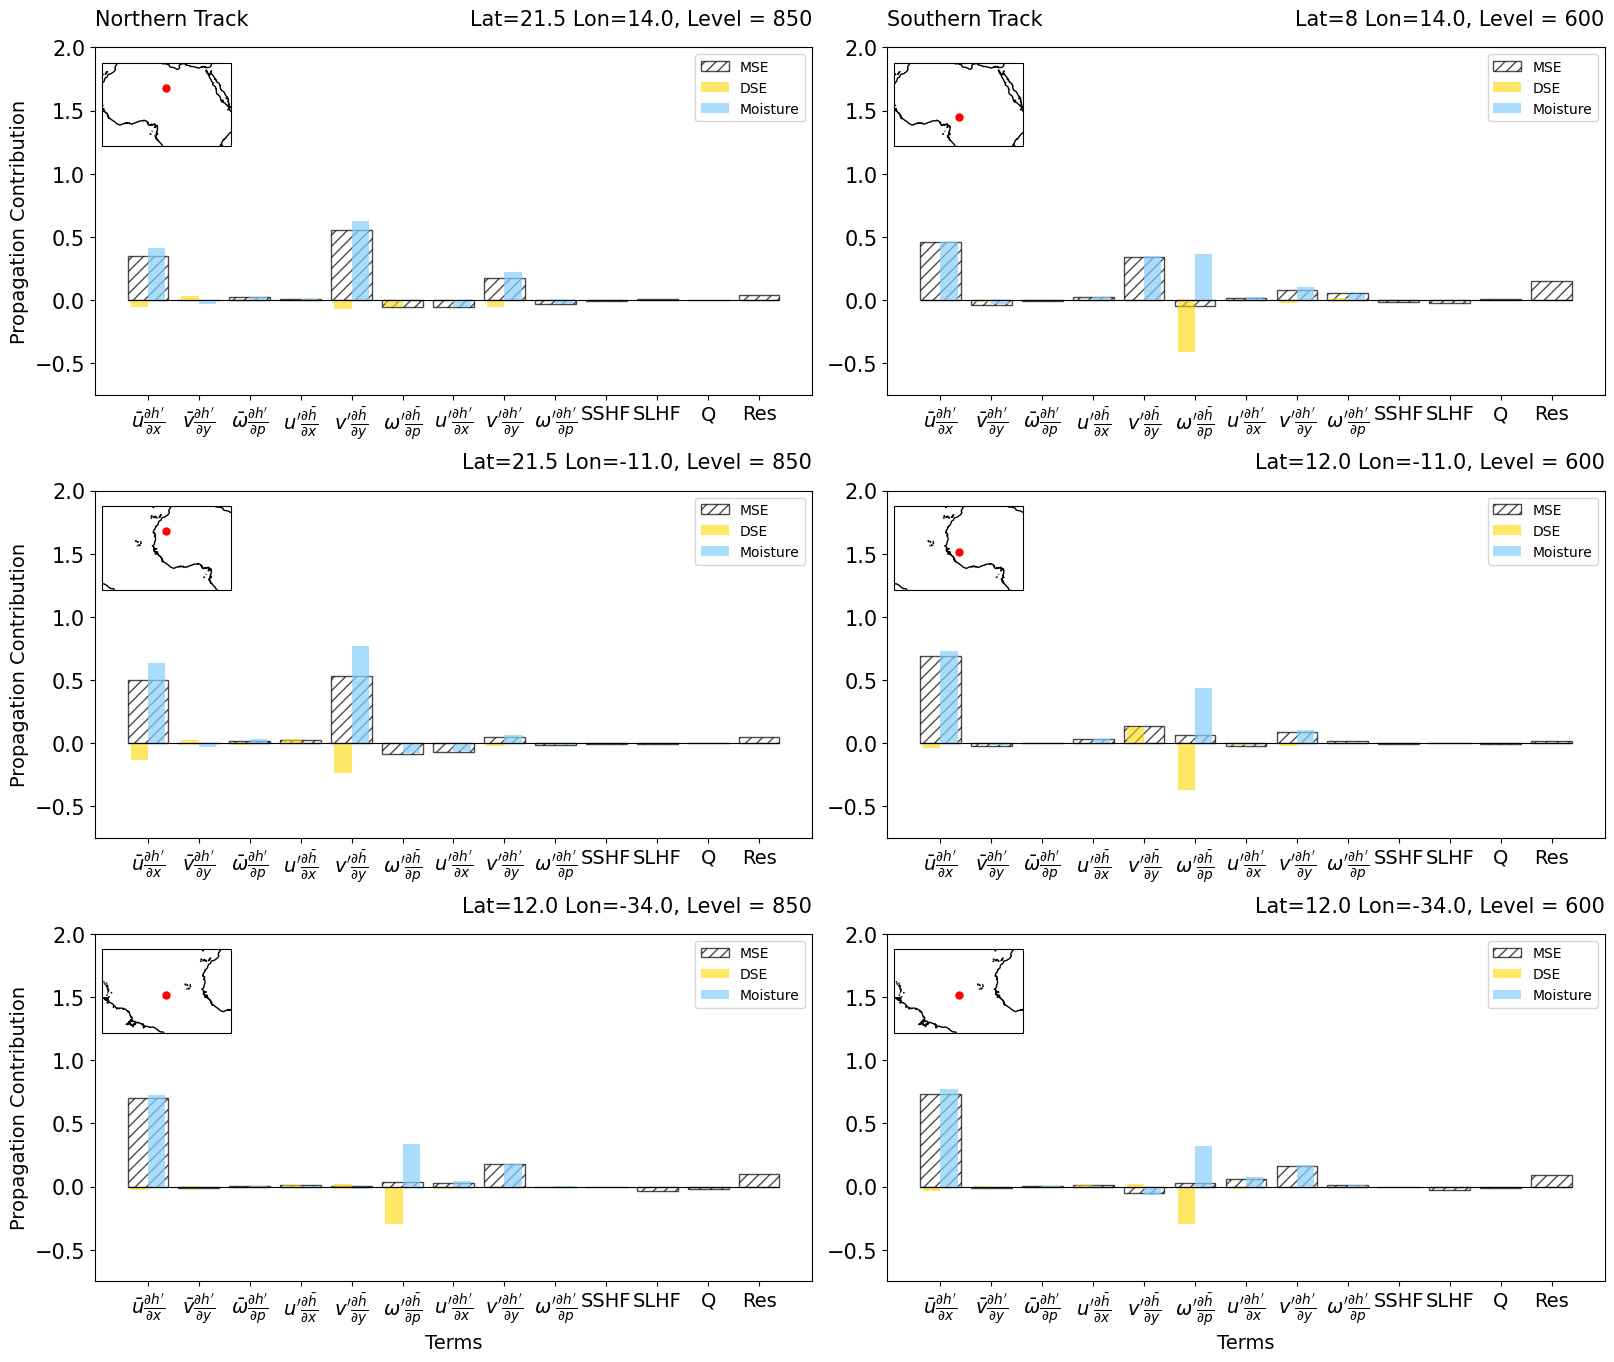

In [12]:
fig, ax = plt.subplots(3,2,constrained_layout=True)
# Set figure size (width, height) in inches
fig.set_size_inches((16,14))
plt.rcParams['savefig.dpi'] = 255

for j in range(0,2):
    for iplot in range(0,3):
        level = levels[j]
        itrack = itracks[iplot]
        stormTrack = stormTracks[j][iplot]
        mse, mse_tend = mse_func()
        denom = xr.dot(mse_tend,mse_tend, dims=['latitude','longitude'], optimize=True)
        h_proj = mse_projection(mse, mse_tend, 'h')
        s_proj = mse_projection(mse, mse_tend, 's')
        q_proj = mse_projection(mse, mse_tend, 'q')
    
    
        #print( iplot, denom.values)
        # zero out fluxes and residual since they do not belong here 
        s_proj[9:13] = [0., 0., 0., 0.]
        q_proj[9:13] = [0., 0., 0., 0.]
    
        lonRef = mse.attrs['lonRef'] 
        latRef = mse.attrs['latRef'] 
     
        #title = location[iplot]
        #title = location[iplot]
        #title = 'Northern Track'
        
        plotting()
        # Add the map subplot to the existing figure
        inset_ax = inset_axes(ax[iplot,j],
                        width="18%", # width = 30% of parent_bbox
                        height=1.0, # height : 1 inch
                        loc=2, #bbox_transform=ax.transAxes,
                        axes_class=cartopy.mpl.geoaxes.GeoAxes,
                        axes_kwargs=dict(map_projection=ccrs.PlateCarree()))
        minlon = lonRef - 30.
        maxlon = lonRef + 30.
        minlat = -5.
        maxlat = 30.
    
        #Set the extent or specific region for the inset map
        inset_ax.set_extent([minlon, maxlon, minlat, maxlat])  
    
        #Add coastlines and other features to the inset map
        inset_ax.add_feature(cfeature.COASTLINE, zorder=1)
        inset_ax.plot(lonRef, latRef, marker='o', markersize=5, color='red', transform=ccrs.PlateCarree())
    
gv.set_titles_and_labels(ax[0,0],
                         lefttitle=Ltitle[0],
                         lefttitlefontsize=15)
gv.set_titles_and_labels(ax[0,1],
                         lefttitle=Ltitle[1],
                         lefttitlefontsize=15)

#ax[0].set_ylabel('Contribution to Maintenance', fontsize=18)
ax[2,0].set_xlabel('Terms', fontsize=14)
ax[2,1].set_xlabel('Terms', fontsize=14)

ax[0,0].set_ylabel('Propagation Contribution', fontsize=14)
ax[1,0].set_ylabel('Propagation Contribution', fontsize=14)
ax[2,0].set_ylabel('Propagation Contribution', fontsize=14)

plt.subplots_adjust(top=0.925)  # Adjust 'top' to increase space
#plt.suptitle('Relative Contribution to Propagation', weight='bold', fontsize = 20)
#plt.savefig('propagation_projections.png', bbox_inches='tight')